In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

In [2]:
class EvolutionaryPrisonersDilemma:
    def __init__(self, size, b, K, include_second_neighbors=True):
        """
        Initialize the simulation.
        
        Args:
            size: Size of the square lattice
            b: Temptation to defect parameter
            K: Noise parameter for irrational choices
            include_second_neighbors: Whether to include diagonal (second) neighbors
        """
        self.size = size
        self.b = b  # temptation to defect
        self.K = K  # noise parameter
        self.include_second_neighbors = include_second_neighbors
        self.lattice = np.random.choice([0, 1], size=(size, size))  # random lattice (0: Defector, 1: Cooperator)
        
    def get_neighbors(self, x, y):
        """
        Get the coordinates of neighbors.
        First neighbors: orthogonal positions
        Second neighbors: diagonal positions
        Return: List[Tuple[int, int]]
        """
        neighbors = []
        # First neighbors (orthogonal)
        first_neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        for dx, dy in first_neighbors:
            nx, ny = (x + dx) % self.size, (y + dy) % self.size
            neighbors.append((nx, ny))
            
        if self.include_second_neighbors:
            # Second neighbors (diagonal)
            second_neighbors = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
            for dx, dy in second_neighbors:
                nx, ny = (x + dx) % self.size, (y + dy) % self.size
                neighbors.append((nx, ny))
                
        return neighbors
    
    def calculate_payoff(self, x, y):
        """Calculate total payoff for player at position (x,y)."""
        player = self.lattice[x, y]
        payoff = 0
        
        # Self interaction (R=1 for C-C, 0 otherwise)
        if player == 1:
            payoff += 1
            
        # Neighbor interactions
        for nx, ny in self.get_neighbors(x, y):
            neighbor = self.lattice[nx, ny]
            if player == 1 and neighbor == 1:  # C-C: payoff = 1
                payoff += 1
            elif player == 0 and neighbor == 1:  # D-C: payoff = b
                payoff += self.b
                
        return payoff
    
    def strategy_adoption_probability(self, payoff_diff):
        """Calculate probability of strategy adoption using Fermi function."""
        if self.K == 0:
            return 1
        return 1 / (1 + np.exp(-payoff_diff / self.K))
    
    def step(self):
        """Perform one Monte Carlo step."""
        # Randomly select a player
        x = np.random.randint(0, self.size)
        y = np.random.randint(0, self.size)
        
        neighbors = self.get_neighbors(x, y)  # Get its neighbors
        nx, ny = neighbors[np.random.randint(0, len(neighbors))]   # Randomly select one of the neighbors
        
        # Calculate payoffs
        payoff_focal = self.calculate_payoff(x, y)
        payoff_neighbor = self.calculate_payoff(nx, ny)
        
        prob = self.strategy_adoption_probability(payoff_neighbor - payoff_focal)  # probability of strategy adoption
        if np.random.random() < prob:    # update strategy
            self.lattice[x, y] = self.lattice[nx, ny]
    
    def get_cooperator_density(self):
        """Calculate the density of cooperators."""
        return np.mean(self.lattice)
    
    def visualize(self):
        """Visualize the current state of the lattice."""
        plt.figure(figsize=(6, 6))
        plt.imshow(self.lattice, cmap='binary_r')
        plt.title(f'Cooperator density: {self.get_cooperator_density():.3f}\n'
                 f'b={self.b}, K={self.K}')
        plt.colorbar(ticks=[0, 1], label=['Defector', 'Cooperator'])
        plt.show()
        
    def visualize_portion(self):
        """Visualize the current state of the lattice."""
        plt.figure(figsize=(6, 6))
        plt.imshow(self.lattice[:100, :100], cmap='binary_r')
        plt.title(f'A 100x100 portion of lattice\n'
                 f'c={self.get_cooperator_density():.3f}, b={self.b}, K={self.K}')
        plt.colorbar(ticks=[0, 1], label=['Defector', 'Cooperator'])
        plt.show()

In [3]:
def run_simulation(size, b, k, steps, game, include_second_neighbors=True, plot_all=True):
    """
    Run the simulation for specified number of steps.
    
    Args:
        size: Lattice size
        b: Temptation to defect
        K: Noise parameter
        steps: Number of Monte Carlo steps
        include_second_neighbors: Whether to include diagonal neighbors
    
    Returns:
        Tuple of time points and corresponding cooperator densities(Tuple[list, list])
    """
    densities = [game.get_cooperator_density()]
    times = [0]
    
    for step in range(1, steps + 1):
        game.step()
        if step % (size * size) == 0:  # Record after each Monte Carlo step
            densities.append(game.get_cooperator_density())
            times.append(step // (size * size))
            
    if plot_all:       
        plt.figure(figsize=(5, 3))
        plt.plot(times, densities)
        plt.xlabel('Monte Carlo Steps')
        plt.ylabel('Cooperator Density')
        plt.title(f'Evolution of Cooperator Density (b={b}, K={k})')
        plt.savefig(f'evol_b={b}_K={k}_{include_second_neighbors}.png')
        plt.grid(True)
        plt.show()
    
    return times, densities

In [4]:
def plot_phase_diagram(size, k, bs, steps_per_b, include_second_neighbors=True):
    """
    Generate a phase diagram showing cooperator density vs temptation to defect.
    """
    densities = []
    for b in bs:
        game = EvolutionaryPrisonersDilemma(LATTICE_SIZE, b, k, include_second_neighbors=strategy)
        _, density_evolution = run_simulation(size, b, k, steps_per_b, game, include_second_neighbors, plot_all=False)
        final_density = np.mean(density_evolution[-10:])  # Take the average of the last few measurements to get steady state
        densities.append(final_density)  
    
    plt.figure(figsize=(5, 3))
    plt.plot(bs, densities, 'b-', marker='o')
    plt.xlabel('Temptation to defect(b)')
    plt.ylabel('Cooperator Density(c)')
    plt.title(f'Phase Diagram (K={k})')
    plt.grid(True)
    plt.savefig(f'phase_K={k}_{include_second_neighbors}.png')
    plt.show()
    
    return densities

In [5]:
LATTICE_SIZE = 400
B = 1.4  # Temptation to defect
K = 0.02  # Noise parameter
STEPS = 100 * LATTICE_SIZE * LATTICE_SIZE  # Number of individual updates
bs = np.linspace(1.0, 2.0, 21)

Initial cooperator density: 0.500
Look at second neighbors: True


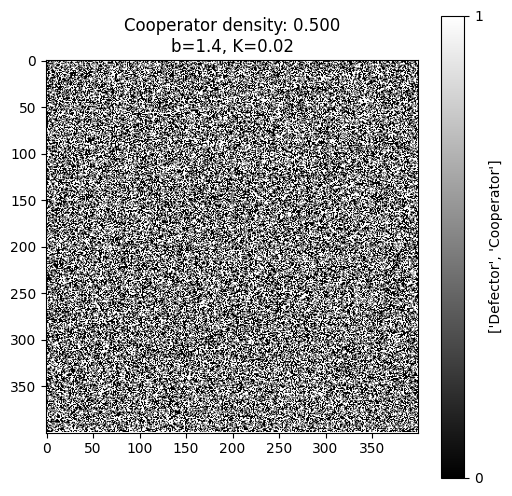

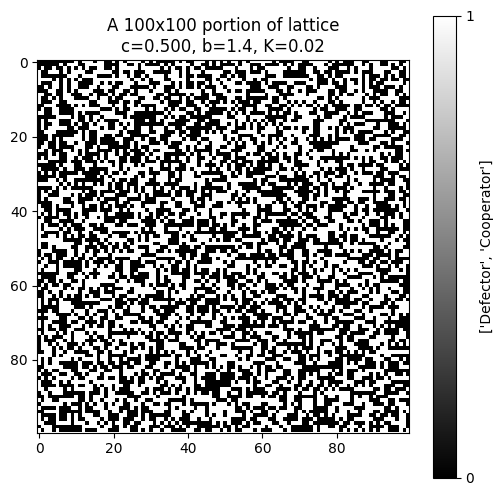

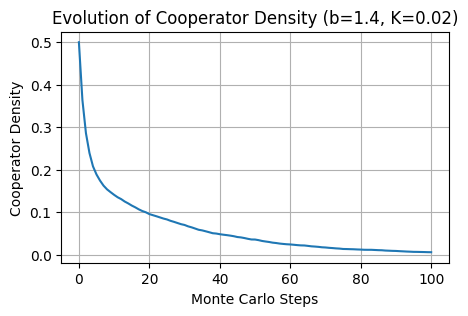

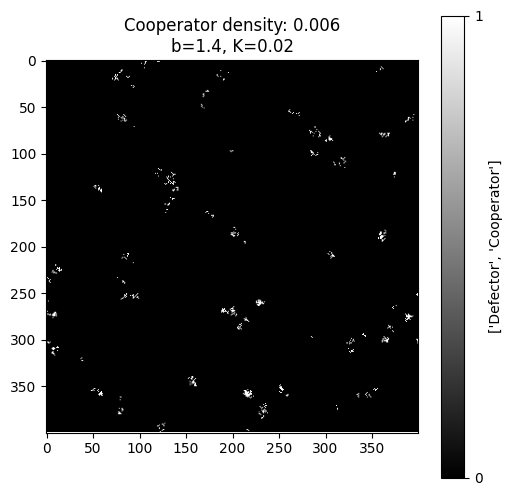

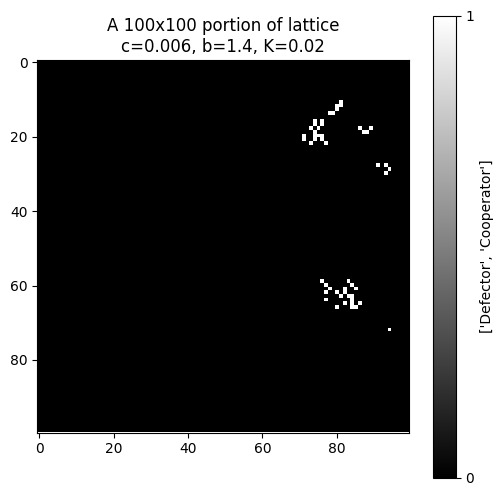

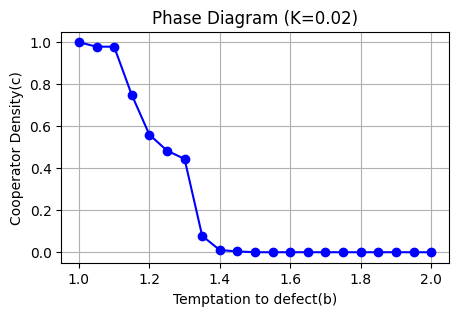

Initial cooperator density: 0.501
Look at second neighbors: False


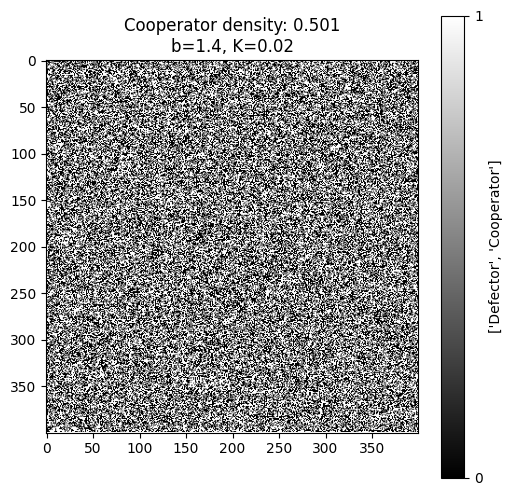

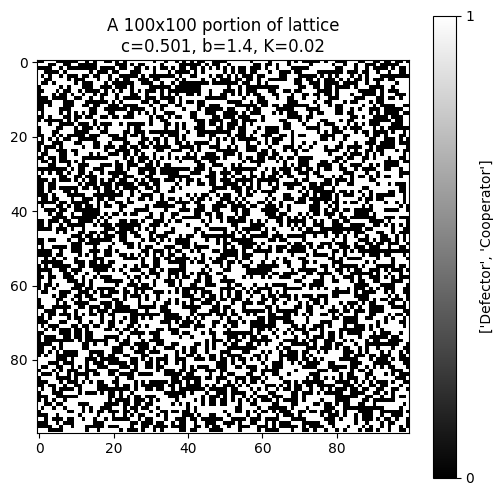

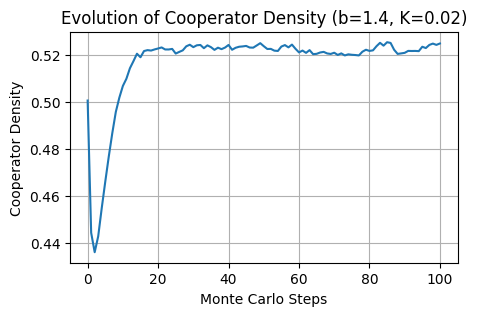

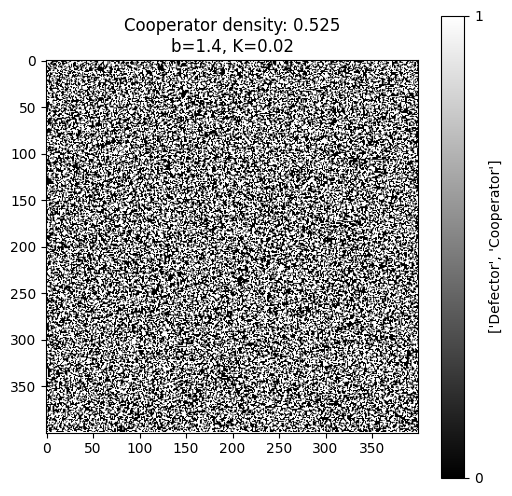

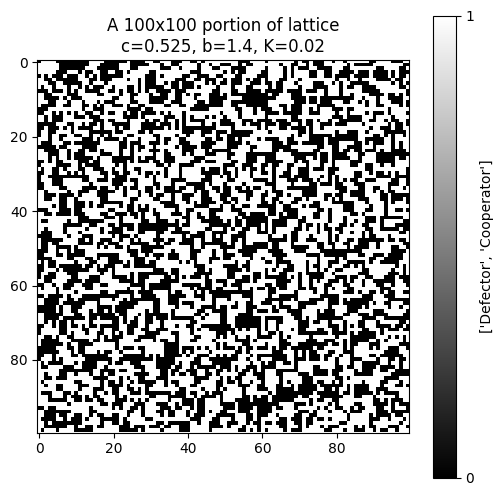

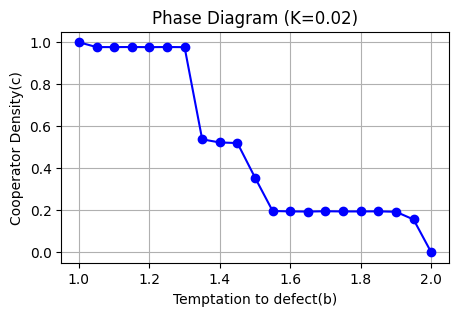

In [6]:
strategies = [True, False]
dens = list()
for strategy in strategies: 
    game = EvolutionaryPrisonersDilemma(LATTICE_SIZE, B, K, include_second_neighbors=strategy)
    print(f"Initial cooperator density: {game.get_cooperator_density():.3f}\nLook at second neighbors: {strategy}")
    game.visualize()    # Show initial state
    game.visualize_portion()
    times, densities = run_simulation(LATTICE_SIZE, B, K, STEPS, game, include_second_neighbors=strategy)    # Run and plot evolution    
    game.visualize()   # Show final state
    game.visualize_portion()
    densities = plot_phase_diagram(LATTICE_SIZE, K, bs, STEPS, include_second_neighbors=strategy)   # Generate phase diagram
    dens.append(densities)

In [7]:
dens

[[1.0,
  0.978839375,
  0.9787675,
  0.7496025000000001,
  0.559991875,
  0.48411625,
  0.444016875,
  0.077769375,
  0.01029125,
  0.0037193749999999996,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  0.97686,
  0.9767956250000001,
  0.9771749999999999,
  0.97655125,
  0.97710625,
  0.9765650000000001,
  0.5375487499999999,
  0.52268,
  0.5198937499999999,
  0.355325,
  0.19628687500000003,
  0.19440125,
  0.193626875,
  0.19509625,
  0.1942325,
  0.194195,
  0.19465125,
  0.19258750000000002,
  0.155864375,
  0.0]]

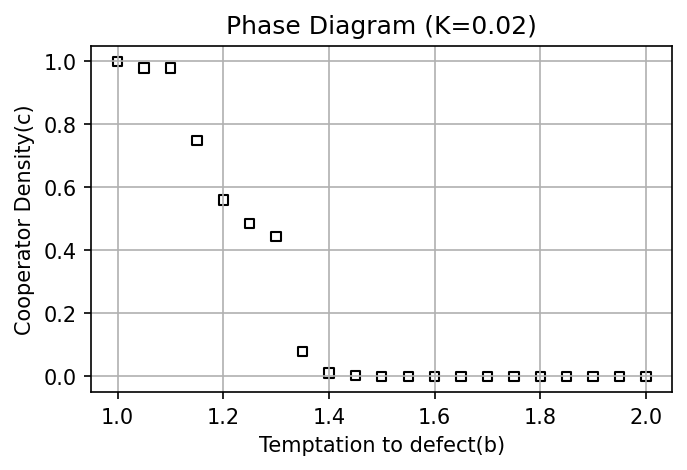

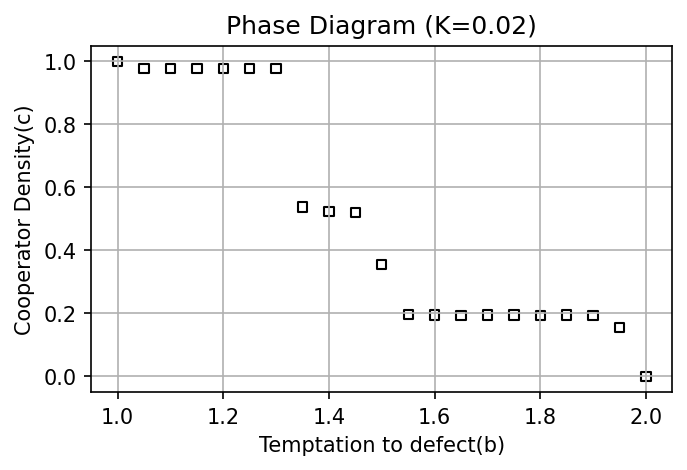

In [14]:
for i, den in enumerate(dens):
    plt.figure(figsize=(5, 3), dpi=150)
    plt.scatter(bs, den, marker='s', facecolors='none', s=20, edgecolor='k')
    plt.xlabel('Temptation to defect(b)')
    plt.ylabel('Cooperator Density(c)')
    plt.title(f'Phase Diagram (K={K})')
    plt.grid(True)
    plt.savefig(f'scatter_phase_K={K}_{i}.png')
    plt.show()